# Imports

In [1]:
import os
import numpy as np
import imghdr

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Tensorflow version 2.7.0
import tensorflow as tf




Populating the interactive namespace from numpy and matplotlib


# Tensorflow check

In [2]:
print('GPU list ', tf.config.list_physical_devices('GPU'))
print('Tensorflow verison :', tf.__version__)

GPU list  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow verison : 2.7.0


# JPEG files errors drop

In [3]:
data_dir = os.path.realpath("C:/Users/emeri/data/PetImages")

In [4]:
#Dogs

def RemoveBuggedDogFiles():
    dog_data_dir = os.path.join(data_dir, "Dog")
    dog_data_imgaes = os.listdir(dog_data_dir)

    i = 0
    for image in dog_data_imgaes:
        image = os.path.join(dog_data_dir, image)
        if not imghdr.what(image) == "jpeg":
            os.remove(image)
            i+=1
    print(i)
    
#RemoveBuggedFiles()

In [5]:
#Cats
def RemoveBuggedCatFiles():
    cat_data_dir = os.path.join(data_dir, "Cat")
    cat_data_imgaes = os.listdir(cat_data_dir)

    i = 0
    for image in cat_data_imgaes:
        image = os.path.join(cat_data_dir, image)
        if not imghdr.what(image) == "jpeg":
            os.remove(image)
            i+=1
    print(i)
    
#RemoveBuggedCatFiles()

# Data load

In [6]:
data_dir = os.path.realpath("C:/Users/emeri/data/PetImages")

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed = 123,
  image_size=(128, 128))

Found 24769 files belonging to 2 classes.
Using 19816 files for training.


In [8]:
val_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed = 123,
  image_size=(128, 128))

Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


# Data Infos

In [9]:
for image_batch, labels_batch in train_data.take(1):
    print('Batch shape :', image_batch.shape)
    print('Batch label shape :', labels_batch.shape)
    

print('Class names :', train_data.class_names)

Batch shape : (32, 128, 128, 3)
Batch label shape : (32,)
Class names : ['Cat', 'Dog']


# Data samples image display

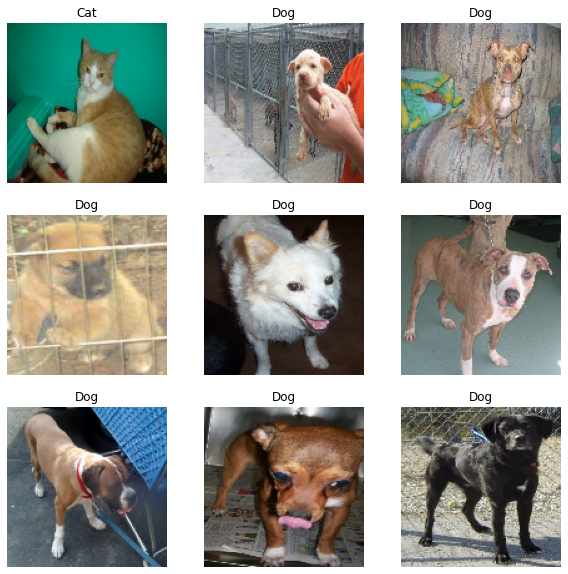

In [10]:
class_names = train_data.class_names

for image_batch, labels_batch in train_data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Model (Sandbox)

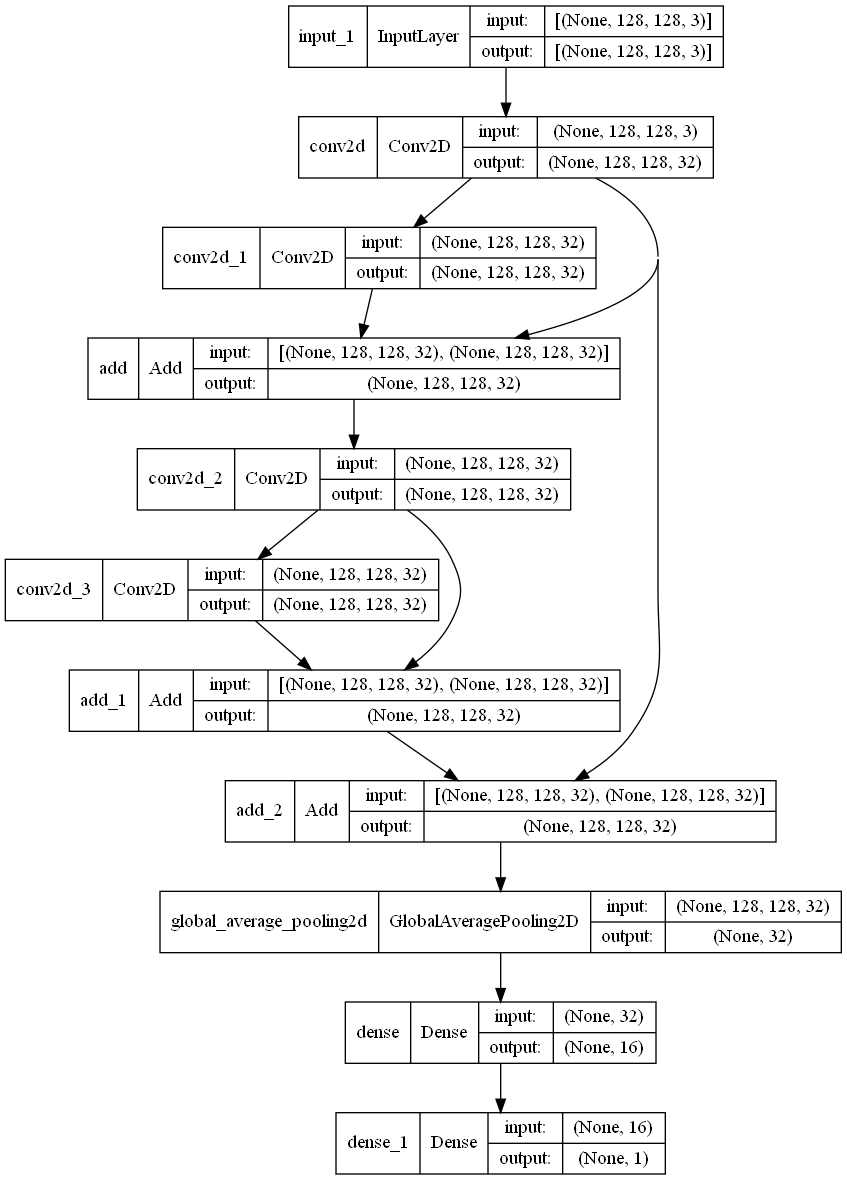

In [11]:
input = tf.keras.Input(shape=(128,128,3))

layer1 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu')(input)
layer2 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu')(layer1)
layer3 = tf.keras.layers.Add()([layer1,layer2])
layer4 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu')(layer3)
layer5 = tf.keras.layers.Conv2D(filters = 32, padding='same', kernel_size=3, activation='relu')(layer4)
layer6 = tf.keras.layers.Add()([layer4,layer5])
layer7 = tf.keras.layers.Add()([layer1,layer6])
pool = tf.keras.layers.GlobalAveragePooling2D()(layer7)
layer_fc = tf.keras.layers.Dense(16, activation='relu')(pool)
output = tf.keras.layers.Dense(1, activation='sigmoid')(layer_fc)
model = tf.keras.Model(inputs=[input], outputs=[output])

tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
def CustomLossTest(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce( y_true, y_pred )
    return loss

In [14]:
model.compile(optimizer='Adam',
              loss=CustomLossTest,
              metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=5)#, callbacks=[callback]

Epoch 1/5
620/620 [==============================] - 19s 29ms/step - loss: 0.7915 - accuracy: 0.5480 - val_loss: 0.6534 - val_accuracy: 0.5845
Epoch 2/5
620/620 [==============================] - 18s 28ms/step - loss: 0.6551 - accuracy: 0.6025 - val_loss: 0.6296 - val_accuracy: 0.6309
Epoch 3/5
620/620 [==============================] - 17s 28ms/step - loss: 0.6194 - accuracy: 0.6525 - val_loss: 0.6139 - val_accuracy: 0.6568
Epoch 4/5
620/620 [==============================] - 17s 28ms/step - loss: 0.5845 - accuracy: 0.6862 - val_loss: 0.6073 - val_accuracy: 0.6659
Epoch 5/5
620/620 [==============================] - 17s 28ms/step - loss: 0.5645 - accuracy: 0.7033 - val_loss: 0.5568 - val_accuracy: 0.7210


In [16]:
model.predict(val_data)

array([[-0.5053309 ],
       [-0.578415  ],
       [-0.400378  ],
       ...,
       [-0.4924283 ],
       [-0.07779652],
       [-0.70204246]], dtype=float32)

In [ ]:
val_data_batch_sample = val_data.take(1)
class_names = train_data.class_names
predictions = model.predict(val_data_batch_sample)


for image_batch, labels_batch in val_data_batch_sample:
    plt.figure(figsize=(10, 10))
    
    nbr_image = 9
    nbr_correct = 0
    for i in range(nbr_image):
        
        modelPredict = model.predict(np.expand_dims(image_batch[i], axis=0))
        print(modelPredict)
        print(predictions[i][0])
        predicted = int(np.rint(modelPredict[0][0]))
        #predicted = int(np.rint(predictions[i][0]))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]] + '(Predicted : ' + class_names[predicted] + ')')#(class_names[labels_batch[i]])
        plt.axis("off")
        
        if class_names[predicted] == class_names[labels_batch[i]]:
            nbr_correct += 1
    print('Accuracy :', (nbr_correct/nbr_image))
        
    break

In [ ]:
val_data_batch_sample = val_data.take(1)
class_names = train_data.class_names

for image_batch, labels_batch in val_data_batch_sample:
    nbr_image = 32
    nbr_correct = 0
    for i in range(nbr_image):
        
        modelPredict = model.predict(np.expand_dims(image_batch[i], axis=0))
        predicted = int(np.rint(modelPredict[0][0]))
        
        if class_names[predicted] == class_names[labels_batch[i]]:
            nbr_correct += 1
    print('Accuracy :', (nbr_correct/nbr_image))
        
    break